# Predict the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 70/20/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 704.69
- MAE: 554.11
- MAPE: 1.69 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> CMG - 7 2 1
split = 0  # 7 2 1
stock = 1  # CMG

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1247,2024-02-26,39900,40200,39500,40000,102000,CMG
1248,2024-02-27,40000,40200,39400,40200,135100,CMG
1249,2024-02-28,40200,40200,39600,40000,177200,CMG
1250,2024-02-29,40000,40000,37600,39950,347700,CMG


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [39]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [40]:
# Shape of the dataframe
df.shape

(1252, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1252.000000,1252.000000
mean,25239.357827,25802.539137
std,8728.202150,8986.348803
min,10780.000000,10880.000000
25%,17455.000000,17710.000000
50%,25175.000000,25925.000000
75%,32340.000000,33325.000000
max,43600.000000,44150.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

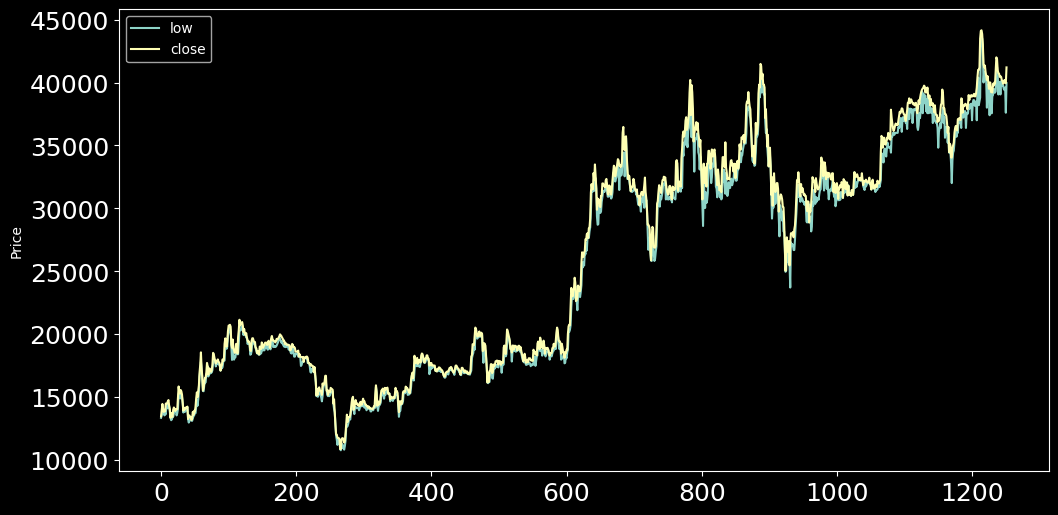

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(-0.7532061524789402,
 0.832482618456889,
 12,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 19254.366836531663)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.659
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.628
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


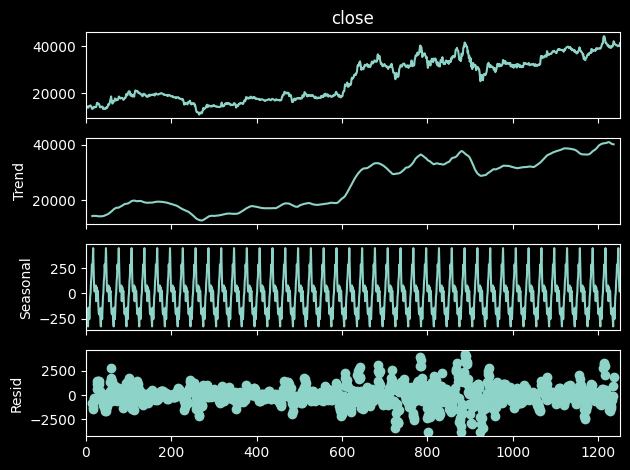

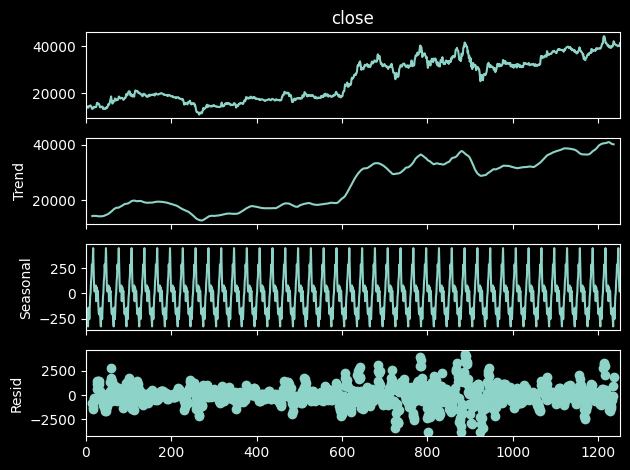

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-14.485934123730853,
 6.2611761040200186e-27,
 3,
 871,
 {'1%': -3.4378800537375045,
  '5%': -2.864864011317803,
  '10%': -2.5685399483682003},
 13239.229519591481)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

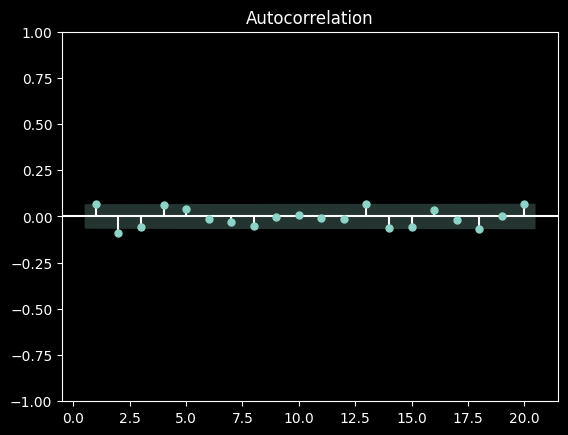

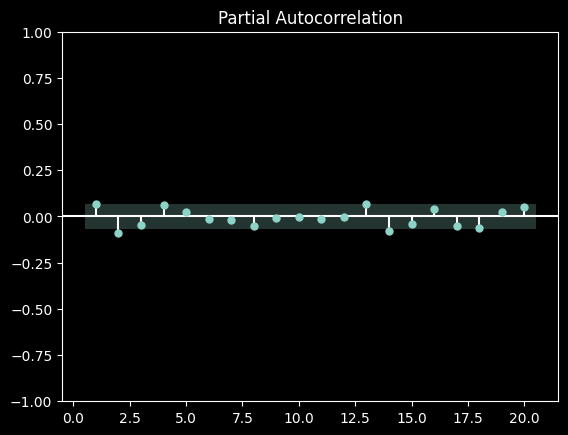

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=13572.956, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=13576.821, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=13575.055, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=13574.399, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=13576.345, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=13571.047, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=13569.049, Time=0.13 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=13571.048, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=13572.817, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=13571.474, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[5] intercept   : AIC=13570.918, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[5] intercept   : AIC=13571.084, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=13574.537, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[5] intercept   : AIC=13571.341, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0

In [56]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  876
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -6779.287
Date:                Sun, 26 May 2024   AIC                          13568.574
Time:                        03:40:17   BIC                          13592.445
Sample:                             0   HQIC                         13577.706
                                - 876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2216      0.151      1.465      0.143      -0.075       0.518
ar.L2         -0.5701      0.140     -4.065      0.000      -0.845      -0.295
ma.L1         -0.1495      0.157     -0.953      0.3

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 5),
)

model_fit = model1.fit()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([34426.34114621, 35150.01065479, 34185.09133956, 34240.28795736,
       35173.96143081, 36315.58151355, 36315.49529635, 36470.81206063,
       37329.49273976, 39795.9073971 , 39156.46617214, 39649.74953407,
       40800.74381249, 39512.72638658, 39868.9865258 , 39942.06552855,
       39366.56838253, 39439.64738519, 37439.10968739, 36580.43140614,
       36863.61254144, 35575.59511957, 34826.53534231, 34150.55456771,
       34150.55456771, 34936.1538463 , 34150.55456771, 32076.93786724,
       30359.58130474, 31291.33858865, 31145.18058333, 31327.87808998,
       32360.11900255, 31428.36171864, 31894.24036059, 32506.27700787,
       32506.27700787, 31720.67772928, 30505.73931006, 29071.56388287,
       31327.87808998, 31072.10158067, 30861.99944803, 30213.42329942,
       30861.99944803, 29427.82402083, 29427.82402083, 28212.88560162,
       26495.52903912, 26568.60804178, 27929.70446631, 27253.72369171,
       28359.04360694, 27034.48668373, 26961.40768107, 25353.66962256,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([39560.14108304, 38036.63125985, 39437.64465572, 38725.51174559,
       39220.71120309, 39293.55087192, 38151.60523817, 39010.30740305,
       38005.47351436, 39293.48925381, 38005.47188025, 38580.96912017,
       38361.73209873, 38042.01145806, 38361.73209594, 38297.78796871,
       37292.95168206, 38042.01145932, 38005.471958  , 37439.10968739,
       37402.57018606, 37292.95168207, 37292.95168207, 36936.6915441 ,
       35502.51611691, 36653.5104088 , 36936.6915441 , 37292.95168207,
       36936.6915441 , 37795.36982535, 37941.52783067, 38398.27159729,
       37292.95168207, 37758.83032402, 36224.17126817, 36863.61254144,
       37009.77054676, 36790.53353878, 35867.91113021, 36580.43140614,
       35146.25597894, 35219.3349816 , 35219.3349816 , 34360.65670035,
       32934.70266096, 34579.89370833, 35146.25597894, 35292.41398426,
       35931.85525753, 36580.43140614, 36717.45453612, 36297.25027083,
       36717.45453612, 36580.43140614, 37512.18869005, 37329.4911834 ,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1247,39500,40000
1248,39400,40200
1249,39600,40000
1250,37600,39950


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[40206.36956868 40284.15858208 40271.96195484 40293.31472472
 40316.19631835 40336.9223886  40357.80157549 40378.79086319
 40399.75866515 40420.72238682 40441.68783921 40462.65333727
 40483.61872788 40504.58412793 40525.54953326 40546.51493744
 40567.48034143 40588.44574552 40609.4111496  40630.37655368
 40651.34195776 40672.30736184 40693.27276592 40714.23817
 40735.20357408 40756.16897816 40777.13438224 40798.09978632
 40819.0651904  40840.03059449]


### Plotting the data


In [63]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

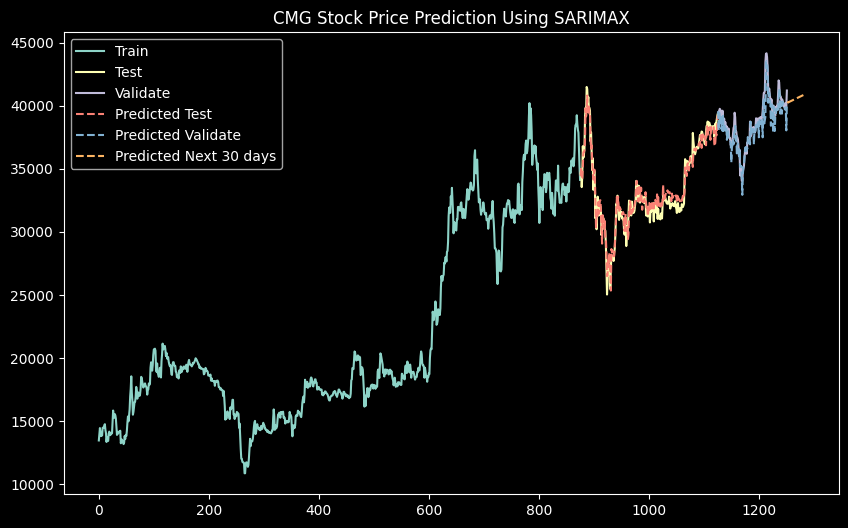

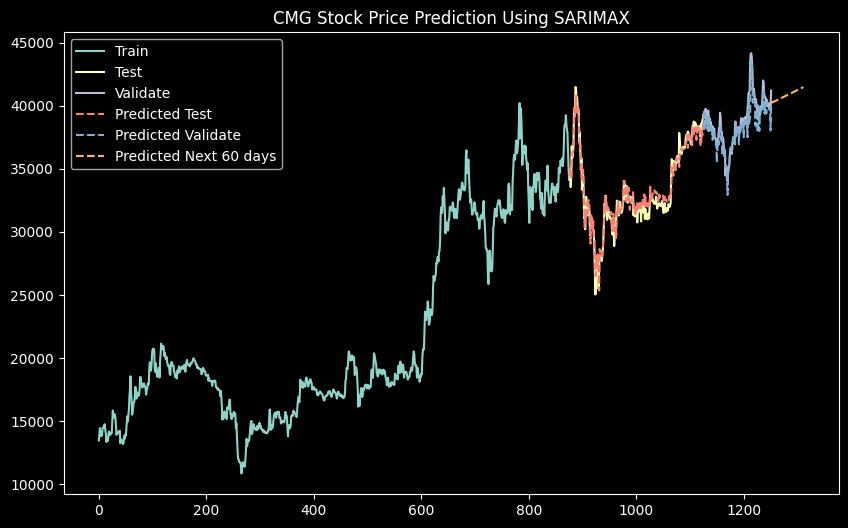

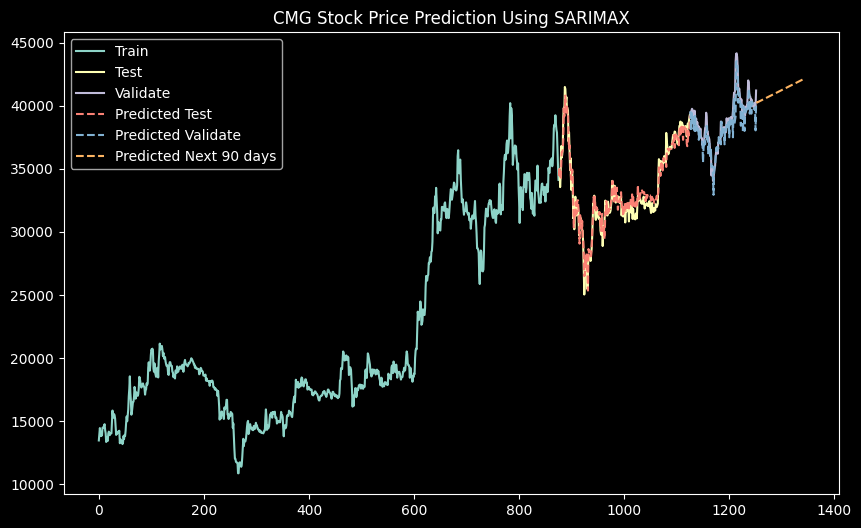

In [64]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 704.6937339730375
MAE on test data: 554.1141348185059
MAPE on test data: 1.6946300086564385 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 863.5865351292285
MAE on validation data: 563.0205902434111
MAPE on validation data: 1.426156434344771 %
